# CORRECTION OF SELECTION BIAS

In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
from model_class_cb import CatBoostXT_BAG
from model_class_lgbm import LightGBMXT_BAG

In [3]:
from model_utils import *

In [4]:
from other_utils import compare_distributions

In [65]:
from ipw import compute_ipw_weights, effective_sample_size

In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import pickle
from scipy.special import expit
import optuna
import json

In [6]:
data_dir = r'E:\Project\Dissertation'

In [7]:
with open(rf'{data_dir}\models\dict_cols.json') as json_file:
    dict_cols = json.load(json_file)

In [8]:
# separate features, target
list_features = dict_cols['list_features']
# features that starts with EXT_
list_ext_features = dict_cols['list_ext_features']
# list ethical features
list_ethical_features = dict_cols['list_ethical_features']
# list categorical features
list_cat_features = dict_cols['list_cat_features']

In [72]:
list_key = dict_cols['list_key']
label_col = dict_cols['label_col']

## Inverted prospensity weighting (IPW)

### Build Acceptance propensity model

In [9]:
df = pd.read_parquet(rf'{data_dir}\data\processed\master_data_simulated_approval_and_reject.parquet')

In [10]:
label_accept = 'flag_accepted'

In [11]:
df.groupby(['flag_train_val','flag_accepted'])['flag_accepted'].count()

flag_train_val  flag_accepted
train           0                196339
                1                 34294
valid           0                 65442
                1                 11436
Name: flag_accepted, dtype: int64

In [12]:
X_accept_train = df.loc[df['flag_train_val']=='train', list_features]
X_accept_valid = df.loc[df['flag_train_val']=='valid', list_features]

y_accept_train = df.loc[df['flag_train_val']=='train', label_accept]
y_accept_valid = df.loc[df['flag_train_val']=='valid', label_accept]

In [13]:
# Check MNAR assumption: OK if set is empty
set(X_accept_train.columns.to_list()).intersection(set(list_ext_features+['flag_has_bureau']))

set()

In [47]:
accept_model = base_model = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [48]:
accept_model.params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 5,
    'l2_leaf_reg': 50,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [49]:
accept_model.fit(X_accept_train, y_accept_train,eval_set=(X_accept_valid, y_accept_valid))

In [50]:
accept_model.evaluate(X_accept_train, y_accept_train)

{'ROC_AUC': 0.8991110507263343, 'PR_AUC': 0.6917703099050095}

In [51]:
accept_model.evaluate(X_accept_valid, y_accept_valid)

{'ROC_AUC': 0.8815137499261219, 'PR_AUC': 0.6812481083066579}

In [54]:
calib_result_summary = accept_model.calibrate(X_accept_valid, y_accept_valid, method='isotonic')

Brier score: 0.080759 | ECE: 0.074263


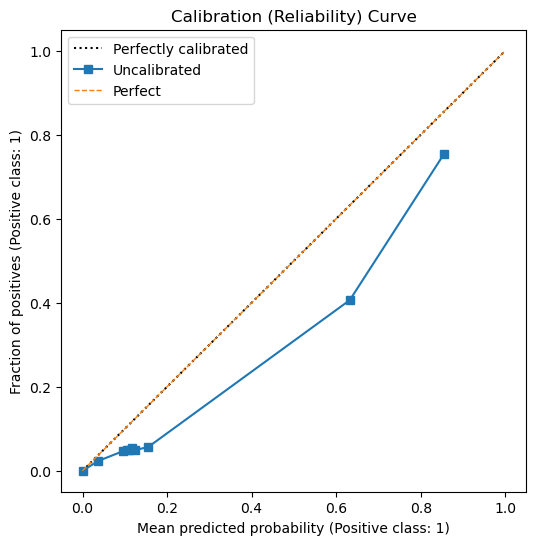

In [55]:
_ = accept_model.plot_calibration_curve(X_accept_valid, y_accept_valid, n_bins=10, strategy="quantile", use_calibrated=False)

Brier score: 0.071226 | ECE: 0.000000


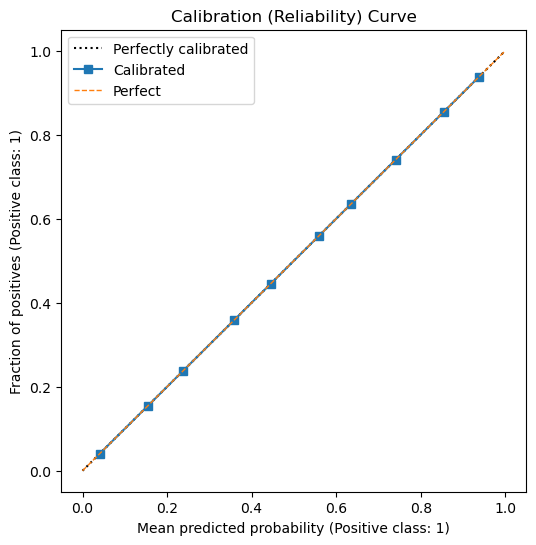

In [56]:
tbl = accept_model.plot_calibration_curve(X_accept_valid, y_accept_valid, n_bins=10, strategy="uniform",
                                   use_calibrated=True, return_table=True)

In [61]:
with open(rf'{data_dir}\models\accept_propensity_model_cb.pkl', 'wb') as f:
    pickle.dump(accept_model, f)

In [83]:
# load model
with open(rf'{data_dir}\models\accept_propensity_model_cb.pkl', 'rb') as f:
    accept_model = pickle.load(f)

### Improve base model with IPW

In [62]:
acc_mask = (df["flag_accepted"].values == 1)

In [70]:
df["flag_accepted"].value_counts()

flag_accepted
0    261781
1     45730
Name: count, dtype: int64

In [88]:
p_accept=accept_model.predict_proba_calib(df[list_features])[:,1]

In [130]:
p_accept[acc_mask]

array([0.04793814, 0.86320755, 0.72641509, ..., 0.05173137, 0.37735849,
       0.67410714])

In [147]:
w_all = np.sqrt(compute_ipw_weights(
    accept=df["flag_accepted"].values,
    p_accept=p_accept,
    stabilize=False, trim_quantiles=(0.05, 0.95), cap_max=10
))
print("Train ESS (accepted only):", effective_sample_size(w_all[acc_mask]))

Train ESS (accepted only): 37367.70747800159


In [148]:
w_all[acc_mask]

array([3.16227766, 1.07632242, 1.17329595, ..., 3.16227766, 1.62788206,
       1.21796704])

In [149]:
train_mask = (df['flag_train_val']=='train')

In [150]:
X_train = df.loc[acc_mask & train_mask, list_features]
y_train = df.loc[acc_mask & train_mask, label_col].values
w_train = w_all[acc_mask & train_mask]

In [151]:
X_val = df.loc[acc_mask & ~train_mask, list_features]
y_val = df.loc[acc_mask & ~train_mask, label_col].values
w_val = w_all[acc_mask & ~train_mask]

In [152]:
len(y_train), len(y_val)

(34294, 11436)

#### Tunning

In [113]:
study_enhanced_ipw = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2025-09-21 23:53:01,162] A new study created in memory with name: no-name-da8d3968-f98e-41ca-a034-ce5ba405d883


In [117]:
def objective(trial):
    param = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 5),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'border_count': 128,
        'auto_class_weights': 'SqrtBalanced',
        'early_stopping_rounds': None,
        'od_type': 'IncToDec',
        'od_wait': 200,
        'od_pval': 0.01,
        'boosting_type': 'Ordered',
        'bootstrap_type': 'Bernoulli',
        'loss_function': 'Logloss', 
        'eval_metric': 'Logloss',
        'task_type':'GPU',
        'devices':'0',
    }
    
    model = CatBoostXT_BAG(
        num_bag_folds=1,
        num_bag_repeats=1,
        random_state=1,
        cat_features=list_cat_features
        )
    model.params = param
    model.fit(X_train, y_train, weights=w_train, eval_set=(X_val, y_val), eval_set_weights=w_val)
    
    #train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_val)[:,1]
    #train_metric = f_roc_auc(y_train, train_pred)
    val_metric = f_roc_auc(y_val, val_pred)
    
    return val_metric #- 1*abs(val_metric - train_metric)

In [118]:
study_enhanced_ipw.optimize(objective, n_trials=100)

[I 2025-09-21 23:58:13,459] Trial 1 finished with value: 0.6986124986124986 and parameters: {'learning_rate': 0.014263071185663497, 'depth': 3, 'l2_leaf_reg': 26}. Best is trial 1 with value: 0.6986124986124986.
[I 2025-09-21 23:58:58,853] Trial 2 finished with value: 0.6931977113795296 and parameters: {'learning_rate': 0.0814537586347737, 'depth': 4, 'l2_leaf_reg': 91}. Best is trial 1 with value: 0.6986124986124986.
[I 2025-09-22 00:01:29,484] Trial 3 finished with value: 0.7013757286484559 and parameters: {'learning_rate': 0.012355003629410742, 'depth': 3, 'l2_leaf_reg': 10}. Best is trial 3 with value: 0.7013757286484559.
[I 2025-09-22 00:02:29,085] Trial 4 finished with value: 0.6980955071864162 and parameters: {'learning_rate': 0.03960723228000903, 'depth': 5, 'l2_leaf_reg': 93}. Best is trial 3 with value: 0.7013757286484559.
[I 2025-09-22 00:04:14,344] Trial 5 finished with value: 0.6988514852151215 and parameters: {'learning_rate': 0.015876978104643964, 'depth': 3, 'l2_leaf_re

In [119]:
with open(rf'{data_dir}\models\enhanced_ipw_model_optuna_study_cb.pkl', 'wb') as f:
    pickle.dump(study_enhanced_ipw, f)

In [120]:
study_enhanced_ipw.best_params

{'learning_rate': 0.02999050557916954, 'depth': 3, 'l2_leaf_reg': 2}

In [153]:
enhanced_model_ipw = base_model = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [164]:
enhanced_model_ipw.params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'depth': 3,
    'l2_leaf_reg': 2,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 50,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [165]:
enhanced_model_ipw.fit(X_train, y_train, weights=w_train, eval_set=(X_val, y_val), eval_set_weights=w_val)

In [169]:
with open(rf'{data_dir}\models\enhanced_ipw_model_cb.pkl', 'wb') as f:
    pickle.dump(enhanced_model_ipw, f)

In [166]:
enhanced_model_ipw.evaluate(X_train, y_train)

{'ROC_AUC': 0.7448983818694368, 'PR_AUC': 0.19199828463006413}

In [167]:
enhanced_model_ipw.evaluate(X_val, y_val)

{'ROC_AUC': 0.7053002553002552, 'PR_AUC': 0.12066059285611316}

In [168]:
enhanced_model_ipw.evaluate(df.loc[df['flag_train_val']=='valid',list_features],df.loc[df['flag_train_val']=='valid',label_col])

{'ROC_AUC': 0.6859216573151327, 'PR_AUC': 0.16752651009377675}

## Self-learning

### Train weak learner for assigning proxy label to reject dataa